In [43]:
#Import necessary libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix

In [44]:
# Membuat class myCallback untuk menghentikan training ketika akurasi sudah mencapai 86% dan val_acc sudah mencapai 86%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.84 and logs.get('val_acc') > 0.84:
            print("\nAkurasi telah mencapai >86%!")
            self.model.stop_training = True

In [45]:
# Load the dataset
data = pd.read_csv('data/Emotion_classify_Data.csv')

In [46]:
#Exploring the dataset:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  5937 non-null   object
 1   Emotion  5937 non-null   object
dtypes: object(2)
memory usage: 92.9+ KB


In [47]:
data.head(7)

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear
5,i feel jealous becasue i wanted that kind of l...,anger
6,when a friend of mine keeps telling me morbid ...,anger


In [48]:
data.tail(7)

,Comment,Emotion
5930,i think we often feel this way about planting ...,fear
5931,i have lost touch with the things that i feel ...,joy
5932,i begun to feel distressed for you,fear
5933,i left feeling annoyed and angry thinking that...,anger
5934,i were to ever get married i d have everything...,joy
5935,i feel reluctant in applying there because i w...,fear
5936,i just wanted to apologize to you because i fe...,anger


In [49]:
data['Emotion'].value_counts()

Emotion
anger    2000
joy      2000
fear     1937
Name: count, dtype: int64

In [50]:
#Data Preprocessing:
X = data['Comment']
y = data['Emotion']

In [51]:
#Converting labels to numerical format:
le = LabelEncoder()
y = le.fit_transform(y)

In [52]:
#Split the dataset into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
#Tokensize and pad teh sequences:
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_text_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

In [54]:
#Build the deep learning model:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=16, input_length=max_len),
    tf.keras.layers.LSTM(64, dropout=0.1, recurrent_dropout=0.1),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [55]:
# lihat arsitektur model
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 16)           160000    
                                                                 
 lstm_5 (LSTM)               (None, 64)                20736     
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 180931 (706.76 KB)
Trainable params: 180931 (706.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [56]:
from keras.callbacks import TensorBoard
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [59]:
# Compile a Model

"""
Kasus yang dihadapi disini adalah binary class jadi kita harus menggunakan loss function yang bernama binary crossentropy

"""
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='Adam',
    metrics=['acc']  
)

# Train the model

callbacks = myCallback()

history = model.fit(
    X_train_seq, 
    y_train, 
    epochs=10, 
    validation_data=(X_text_seq, y_test), 
    batch_size=32,
    callbacks=[tensorboard_callback]
    )


Epoch 1/10
149/149 [==============================] - 13s 65ms/step - loss: 1.0780 - acc: 0.4083 - val_loss: 0.9581 - val_acc: 0.5884
Epoch 2/10
149/149 [==============================] - 9s 63ms/step - loss: 0.7850 - acc: 0.7065 - val_loss: 0.6929 - val_acc: 0.7618
Epoch 3/10
149/149 [==============================] - 10s 68ms/step - loss: 0.3075 - acc: 0.9250 - val_loss: 0.3471 - val_acc: 0.8897
Epoch 4/10
149/149 [==============================] - 10s 68ms/step - loss: 0.1201 - acc: 0.9752 - val_loss: 0.2473 - val_acc: 0.9268
Epoch 5/10
149/149 [==============================] - 10s 68ms/step - loss: 0.0692 - acc: 0.9861 - val_loss: 0.2757 - val_acc: 0.9082
Epoch 6/10
149/149 [==============================] - 10s 68ms/step - loss: 0.0401 - acc: 0.9916 - val_loss: 0.2312 - val_acc: 0.9226
Epoch 7/10
149/149 [==============================] - 10s 67ms/step - loss: 0.0294 - acc: 0.9952 - val_loss: 0.2481 - val_acc: 0.9242
Epoch 8/10
149/149 [==============================] - 10s 68ms/

In [60]:
# Save the model to a file
model.save('model_emotion.h5')

c:\Users\arief\miniconda3\envs\tf\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [61]:
# Load the saved model
load_model = tf.keras.models.load_model('model_emotion.h5')

<Figure size 640x480 with 0 Axes>

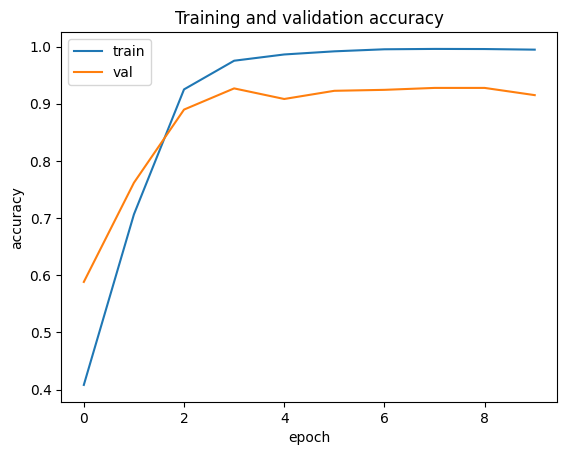

<Figure size 640x480 with 0 Axes>

In [62]:
import matplotlib.pyplot as plt

# Retrieve a list of list results on training and test data sets for each training epoch

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']


# Plot training and validation accuracy per epoch

plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()